## Access the NOAA Climate Data Online Webservice API

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mrahnis/nb-streamgage/blob/main/Weather-01--Access-NOAA-Climate-Data-Online.ipynb)

In [1]:
from os import environ
import requests
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import HTML
from ipyleaflet import Map, Marker, Popup, basemaps, basemap_to_tiles

In [2]:
# your NCDC Climate Data Online web API token.
# my token is set in an os environment variable so as to not appear in the rendered notebook
# follow the directions here to obtain a token: https://www.ncdc.noaa.gov/cdo-web/webservices/v2#gettingStarted

token = environ['NCDC_CDO_TOKEN']

## Map the stations in Lancaster County PA

In [3]:
#lancaster's FIPS code
FIPS = 'FIPS:42071'

stations_response = requests.get(
    'https://www.ncei.noaa.gov/cdo-web/api/v2/stations',
    params={
        'datasetid': 'GHCND',
        'locationid': FIPS,
        'startdate': '2010-05-01',
        'enddate': '2010-05-31',
        'limit': 1000
    },
    headers={
        'Accept': 'application/json',
        'token': token
    },
)

In [4]:
stations = pd.json_normalize((stations_response.json())['results'])
stations

,elevation,mindate,maxdate,latitude,name,datacoverage,id,elevationUnit,longitude
0,198.1,2007-03-15,2022-11-29,40.205520,"ADAMSTOWN 2.5 SSE, PA US",0.7942,GHCND:US1PALN0003,METERS,-76.050854
1,132.3,2009-04-13,2022-11-28,40.063400,"LANCASTER 5.8 WNW, PA US",0.8284,GHCND:US1PALN0007,METERS,-76.407200
2,195.1,2009-04-13,2014-12-31,39.854608,"QUARRYVILLE 2.8 S, PA US",0.7836,GHCND:US1PALN0008,METERS,-76.159741
3,82.3,1948-05-01,2022-11-28,40.049900,"LANCASTER 2 NE FILT PLANT, PA US",0.5458,GHCND:USC00364763,METERS,-76.274200
4,109.7,1952-04-01,2021-10-31,40.119030,"LANDISVILLE 2 NW, PA US",0.8359,GHCND:USC00364778,METERS,-76.426500
5,184.4,1992-08-01,2022-11-27,40.075280,"NEW HOLLAND 2 SE, PA US",0.8428,GHCND:USC00366238,METERS,-76.071470
6,79.2,1978-02-28,2022-10-31,39.795520,"OCTORARO LAKE, PA US",0.8302,GHCND:USC00366508,METERS,-76.044040
7,59.4,1948-05-01,2022-11-28,39.925340,"SAFE HARBOR DAM, PA US",0.3288,GHCND:USC00367732,METERS,-76.389030
8,121.1,1999-03-16,2022-11-27,40.120610,"LANCASTER AIRPORT, PA US",0.8452,GHCND:USW00054737,METERS,-76.294460


In [5]:
# map the stations in Lancaster County, PA
center = (
    (stations['latitude'].min() + stations['latitude'].max())/2,
    (stations['longitude'].min() + stations['longitude'].max())/2,
)

m = Map(
    basemap=basemap_to_tiles(basemaps.OpenStreetMap.Mapnik),
    center=center,
    zoom=9
)

for ix, station in stations.iterrows():
    marker = Marker(
        location=(station['latitude'], station['longitude']),
        draggable=False,
        title=station['name'],
        alt=station['id']
    )
    
    message = HTML()
    message.value = station['name'] + '<br/>' + station['id'] + '<br/>' + station['mindate'] + ' to ' + station['maxdate']

    popup = Popup(
        location=(station['latitude'], station['longitude']),
        child=message,
        close_button=False,
        auto_close=False,
        close_on_escape_key=False
    )
    marker.popup = popup

    m.add_layer(marker)

m

Map(center=[40.00052, -76.23527], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', …

## Retrieve data for one station

In [6]:
station = 'GHCND:USC00364763'

response = requests.get(
    'https://www.ncei.noaa.gov/cdo-web/api/v2/data',
    params={
        'datasetid': 'GHCND',
        'stationid': station,
        'units': 'metric',
        'startdate': '2010-05-01',
        'enddate': '2010-05-31',
        'limit': 1000
    },
    headers={
        'Accept': 'application/json',
        'token': token
    },
)

In [7]:
df = pd.json_normalize((response.json())['results'])

In [8]:
df['datetime'] = pd.to_datetime(df['date'])
df.set_index(df['datetime'])
df

,date,datatype,station,attributes,value,datetime
0,2010-05-01T00:00:00,PRCP,GHCND:USC00364763,",,0,2400",0.0,2010-05-01
1,2010-05-01T00:00:00,SNOW,GHCND:USC00364763,"P,,0,",0.0,2010-05-01
2,2010-05-01T00:00:00,SNWD,GHCND:USC00364763,"P,,0,",0.0,2010-05-01
3,2010-05-01T00:00:00,TMAX,GHCND:USC00364763,",,0,2400",32.8,2010-05-01
4,2010-05-01T00:00:00,TMIN,GHCND:USC00364763,",,0,2400",10.0,2010-05-01
...,...,...,...,...,...,...
181,2010-05-31T00:00:00,SNOW,GHCND:USC00364763,"P,,0,",0.0,2010-05-31
182,2010-05-31T00:00:00,SNWD,GHCND:USC00364763,"P,,0,",0.0,2010-05-31
183,2010-05-31T00:00:00,TMAX,GHCND:USC00364763,",,0,2400",32.2,2010-05-31
184,2010-05-31T00:00:00,TMIN,GHCND:USC00364763,",,0,2400",16.1,2010-05-31


In [9]:
wx = df.pivot(index='datetime', columns='datatype', values='value')
wx.head()

datatype,PRCP,SNOW,SNWD,TMAX,TMIN,TOBS
datetime,,,,,,
2010-05-01,0.0,0.0,0.0,32.8,10.0,18.3
2010-05-02,1.0,0.0,0.0,30.6,18.3,20.0
2010-05-03,34.0,0.0,0.0,27.2,18.3,18.3
2010-05-04,0.0,0.0,0.0,26.1,12.8,13.3
2010-05-05,0.0,0.0,0.0,26.7,4.4,16.1


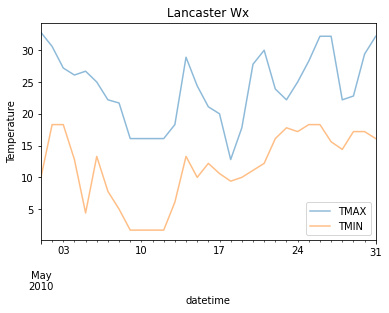

In [10]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

# plot the daily air temperature extremes
ax.set_title('Lancaster Wx')
ax.set_ylabel('Temperature')
wx['TMAX'].plot(ax=ax, linestyle='-', marker=None, alpha=0.5, label='TMAX')
wx['TMIN'].plot(ax=ax, linestyle='-', marker=None, alpha=0.5, label='TMIN')
ax.legend()